# Mini Project 1

Ye Yushi, 12207894

Nie Rong, 20458617

Liu Wing Ki, 20100260

## System Check

We will use pytorch (on Windows Platform) for this project

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


## Data Handling

Download Cifar10 dataset by torchvision.datasets and normalize it.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Examples

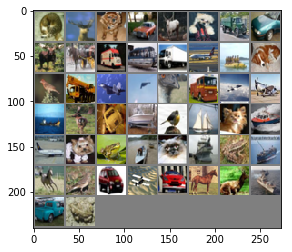

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Feature Extraction from Pretrained DNN models

Load pretrained ResNet18 model using torchvision.models

In [4]:
original_model = models.resnet18(pretrained=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            *list(original_model.children())[:-2] # remove last fully-connected layer
        )
    def forward(self, x):
        x = self.features(x)
        return x
    
net = Net()

Move the net to GPU

In [5]:
device = torch.device("cuda:0")
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Use the pretrained model to do feature extraction.  

In [6]:
features = list()
labels = list()
for data in trainloader:
    image, label = data
    output = net(image.to(device)).squeeze()
    features.append(output.cpu().detach().numpy())
    labels.append(label.numpy())

Now each image is corresponding to a 512-dim vector (depending on the structure of ResNet18).

In [8]:
features = np.vstack(features)
labels = np.concatenate(labels)

We will apply random forest model on these features to do classfication.

In [9]:
from sklearn.ensemble import RandomForestClassifier

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
# Create a random forest Classifier.
clf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training label (the classes
clf.fit(features, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now we do feature extraction on testing set.

In [11]:
features_test = list()
labels_test = list()
for data in testloader:
    image, label = data
    output = net(image.to(device)).squeeze()
    features_test.append(output.cpu().detach().numpy())
    labels_test.append(label.numpy())

features_test = np.vstack(features_test)
labels_test = np.concatenate(labels_test)

Then we can evaluate our random forest classifier on testing set.

In [12]:
labels_predict = clf.predict(features_test)

First 10 predictions

In [13]:
labels_predict[:10]

array([7, 8, 8, 8, 6, 6, 1, 2, 3, 9], dtype=int64)

First 10 ground truth

In [14]:
labels_test[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=int64)

Here is the overall performance:

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for i in range(len(labels_test)):
    label = labels_test[i]
    if label == labels_predict[i]:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 40 %
Accuracy of  bird : 25 %
Accuracy of   cat : 29 %
Accuracy of  deer : 35 %
Accuracy of   dog : 30 %
Accuracy of  frog : 49 %
Accuracy of horse : 34 %
Accuracy of  ship : 41 %
Accuracy of truck : 37 %


## Feature Extraction from Scattering Network

Here we use PyScatWave (https://github.com/edouardoyallon/pyscatwave) to do feature extraction on the first layer.

In [16]:
from scatwave.scattering import Scattering
scat = Scattering(M=32, N=32, J=2).cuda()

C:\Anaconda3\lib\site-packages\scikit_cuda-0.5.2-py3.6.egg\skcuda\cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')
C:\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Then we feed the extracted features to ResNet18

In [65]:
features = list()
labels = list()
for data in trainloader:
    image, label = data
    output = net(scat(images.cuda()).view(50,3,72,72)).view(50, -1)
    features.append(output.cpu().detach().numpy())
    labels.append(label.numpy())

In [66]:
features = np.vstack(features)
labels = np.concatenate(labels)

Again, we apply random forest to do the classification.

In [67]:
# Create a random forest Classifier.
clf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training label (the classes
clf.fit(features, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now we evaluate classification accuracy on testing set

In [68]:
features_test = list()
labels_test = list()
for data in testloader:
    image, label = data
    output = net(scat(images.cuda()).view(50,3,72,72)).view(50, -1)
    features_test.append(output.cpu().detach().numpy())
    labels_test.append(label.numpy())

features_test = np.vstack(features_test)
labels_test = np.concatenate(labels_test)

In [69]:
labels_predict = clf.predict(features_test)

Here is the over all performance

In [70]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for i in range(len(labels_test)):
    label = labels_test[i]
    if label == labels_predict[i]:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 11 %
Accuracy of   car :  2 %
Accuracy of  bird : 11 %
Accuracy of   cat : 19 %
Accuracy of  deer :  8 %
Accuracy of   dog :  7 %
Accuracy of  frog :  6 %
Accuracy of horse : 10 %
Accuracy of  ship : 10 %
Accuracy of truck : 13 %


We can see the performance is even worse! This is abnormal. We will check the scattering network code carefully to see what happened.